In [11]:
# 04_domain_adaptation.ipynb
'''Task:Implement domain adaptation experiments (CORAL & DANN) on processed dataset.  
- Detect or construct source/target domains.
- Run a baseline classifier trained on source and evaluated on target (no adaptation).
- Run CORAL feature alignment and evaluate.
- Run DANN (Domain-Adversarial Neural Network) and evaluate (PyTorch). If PyTorch unavailable, skip DANN gracefully.
- Save models, metrics and plots to `models/` and `reports/`.'''


'Task:Implement domain adaptation experiments (CORAL & DANN) on processed dataset.  \n- Detect or construct source/target domains.\n- Run a baseline classifier trained on source and evaluated on target (no adaptation).\n- Run CORAL feature alignment and evaluate.\n- Run DANN (Domain-Adversarial Neural Network) and evaluate (PyTorch). If PyTorch unavailable, skip DANN gracefully.\n- Save models, metrics and plots to `models/` and `reports/`.'

In [12]:
# Standard imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import time
import json
from pprint import pprint

# Data handling & plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# Joblib / saving
import joblib

# Try PyTorch for DANN
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

# Repro
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if TORCH_AVAILABLE:
    torch.manual_seed(RANDOM_SEED)

# Paths
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"
PLOTS_DIR = ROOT / "plots"
for d in (MODELS_DIR, REPORTS_DIR, PLOTS_DIR):
    d.mkdir(parents=True, exist_ok=True)

timestamp = time.strftime("%Y%m%d_%H%M%S")


In [13]:
def save_json(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"Saved JSON: {path}")

def save_joblib(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(obj, path)
    print(f"Saved joblib: {path}")


In [14]:
# Load processed features (expects processed_features.csv or X_train/X_test splits)
# Strategy: if 'processed_features.csv' with domain column exists, use it; else check X_train/X_test files.
proc_path = DATA_DIR / "processed_features.csv"
proc_no_target_path = DATA_DIR / "processed_features_no_target.csv"

# Attempt to load a dataset that contains both features + domain + target if possible
if proc_path.exists():
    df = pd.read_csv(proc_path)
    print("Loaded:", proc_path)
else:
    # Try train/test split: we'll combine them and look for domain columns
    xtrain = DATA_DIR / "X_train.csv"
    xtest = DATA_DIR / "X_test.csv"
    ytrain = DATA_DIR / "y_train.csv"
    ytest = DATA_DIR / "y_test.csv"
    if xtrain.exists() and xtest.exists() and ytrain.exists() and ytest.exists():
        X_tr = pd.read_csv(xtrain)
        X_te = pd.read_csv(xtest)
        y_tr = pd.read_csv(ytrain).squeeze()
        y_te = pd.read_csv(ytest).squeeze()
        X_tr = X_tr.copy(); X_te = X_te.copy()
        X_tr["__split__"] = "train"
        X_te["__split__"] = "test"
        df = pd.concat([X_tr, X_te], ignore_index=True)
        # Append target if known
        y_combined = pd.concat([y_tr.reset_index(drop=True), y_te.reset_index(drop=True)], ignore_index=True)
        df["__target__"] = y_combined.values
        print("Loaded combined X_train/X_test.")
    else:
        raise FileNotFoundError("No processed_features.csv or train/test splits found in data/. Run preprocessing first.")

display(df.head(3))
print("Shape:", df.shape)

# Heuristics to find domain column names
domain_candidates = [c for c in df.columns if c.lower() in ("domain","site","source","origin","group","cohort","subject","participant","session")]
print("Domain candidates found:", domain_candidates)

# If domain column exists, use it. Otherwise, we will create a synthetic target domain (documented).
if domain_candidates:
    DOMAIN_COL = domain_candidates[0]
    print("Using domain column:", DOMAIN_COL)
else:
    DOMAIN_COL = None
    print("No domain column found — will create a synthetic target domain (covariate shift).")


Loaded: C:\Users\alfiy\ByteBuzz\Notebooks\data\processed_features.csv


,StudentID,EEG_Delta_mean,EEG_Delta_var,EEG_Theta_mean,EEG_Theta_var,EEG_Alpha_mean,EEG_Alpha_var,EEG_Beta_mean,EEG_Beta_var,EEG_Gamma_mean,...,TrialID_Item3,TrialID_Item4,TrialID_Item5,TrialID_Item6,TrialID_Item7,TrialID_Item8,TrialID_Item9,TrialID_spl1,TrialID_spl2,Label
0,-0.947368,-1.370069,-0.487402,-1.005474,-0.619364,-0.775826,-0.232434,-0.248998,-0.418008,-0.620357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,-0.947368,-0.050456,0.607803,-0.220604,0.999145,-0.053297,1.293091,-0.075660,0.003049,-0.219706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,-0.947368,0.268942,0.935666,0.096330,1.478190,0.246744,0.568738,0.032229,-0.082874,-0.350830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Shape: (1448, 55)
Domain candidates found: []
No domain column found — will create a synthetic target domain (covariate shift).


In [15]:
# Identify target column (label) heuristically
target_candidates = [c for c in df.columns if c.lower() in ("target","label","y","class","category","__target__")]
if target_candidates:
    TARGET_COL = target_candidates[0]
else:
    # fallback to last column if apparently categorical/numeric small cardinality
    TARGET_COL = df.columns[-1]
print("Using target column:", TARGET_COL)

# If domain column found, pick most frequent value as source and another as target (or use >1 domains)
if DOMAIN_COL is not None:
    # make sure target column isn't the domain column
    domains = df[DOMAIN_COL].unique().tolist()
    print("Domains:", domains)
    if len(domains) < 2:
        print("Only one domain found — will create synthetic target domain instead.")
        DOMAIN_COL = None

if DOMAIN_COL is None:
    # Create synthetic domain: split by random subset and apply a covariate shift to target domain.
    df = df.reset_index(drop=True)
    # Strategy: sample 30% rows as target domain and shift features by adding gaussian noise scaled per-feature
    rng = np.random.RandomState(RANDOM_SEED)
    n = len(df)
    target_idx = rng.choice(n, size=int(0.3*n), replace=False)
    df["__domain__"] = "source"
    df.loc[target_idx, "__domain__"] = "target_synthetic"

    # Apply a mild covariate shift to target rows only on numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Avoid changing target column if numeric-coded; ensure we don't modify target
    if TARGET_COL in num_cols:
        num_cols.remove(TARGET_COL)
    print(f"Applying covariate shift to {len(num_cols)} numeric columns for synthetic target domain.")
    for c in num_cols:
        sigma = df[c].std() or 1.0
        df.loc[df["__domain__"] == "target_synthetic", c] = df.loc[df["__domain__"] == "target_synthetic", c] + rng.normal(loc=0.5*sigma, scale=0.15*sigma, size=df.loc[df["__domain__"] == "target_synthetic"].shape[0])
    DOMAIN_COL = "__domain__"

# Show counts per domain
display(df.groupby(DOMAIN_COL)[TARGET_COL].agg(["count","nunique"]).rename(columns={"count":"rows","nunique":"classes"}))


Using target column: Label
Applying covariate shift to 54 numeric columns for synthetic target domain.


,rows,classes
__domain__,,
source,1014,2
target_synthetic,434,2


In [16]:
#Prepare feature matrices & scalers
# Features = all columns except target and domain
feature_cols = [c for c in df.columns if c not in (TARGET_COL, DOMAIN_COL)]
# Remove helper columns if present
feature_cols = [c for c in feature_cols if not c.startswith("__")]

print("Feature count:", len(feature_cols))

# Build X_source, X_target, y_source, y_target
source_df = df[df[DOMAIN_COL] != "target_synthetic"]
target_df = df[df[DOMAIN_COL] == "target_synthetic"]

# If the original domain column had different names, ensure 'target' selection is correct
# For general domain column (not synthetic) use label 'target' for one of the other unique domain values
if "target_synthetic" not in df[DOMAIN_COL].unique():
    # choose domain with fewer samples as 'target' for realism
    counts = df[DOMAIN_COL].value_counts()
    source_domain = counts.idxmax()
    target_domain = counts.index[1] if len(counts)>1 else counts.idxmax()
    source_df = df[df[DOMAIN_COL] == source_domain]
    target_df = df[df[DOMAIN_COL] == target_domain]
    print(f"Selected source domain: {source_domain} ({len(source_df)} rows); target domain: {target_domain} ({len(target_df)} rows)")

X_src = source_df[feature_cols].reset_index(drop=True)
y_src = source_df[TARGET_COL].reset_index(drop=True)
X_tgt = target_df[feature_cols].reset_index(drop=True)
y_tgt = target_df[TARGET_COL].reset_index(drop=True)

# Encode target labels
le = LabelEncoder()
y_src_enc = le.fit_transform(y_src)
y_tgt_enc = le.transform(y_tgt)  # if unseen labels will raise — typically same label set

save_joblib(le, MODELS_DIR / f"domain_le_{timestamp}.joblib")

print("Source shape:", X_src.shape, "Target shape:", X_tgt.shape, "Classes:", le.classes_)


Feature count: 54
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\domain_le_20251017_232158.joblib
Source shape: (1014, 54) Target shape: (434, 54) Classes: [0 1]


In [17]:
#Baseline: train on source, test on target
# Simple baseline model (logistic regression)
from sklearn.pipeline import Pipeline

baseline_pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))])
print("Training baseline (source only)...")
baseline_pipe.fit(X_src, y_src_enc)
preds = baseline_pipe.predict(X_tgt)
acc = accuracy_score(y_tgt_enc, preds)
f1 = f1_score(y_tgt_enc, preds, average="macro")
print(f"Baseline (train on source -> test on target) — acc: {acc:.4f}, f1_macro: {f1:.4f}")

baseline_report = classification_report(y_tgt_enc, preds, output_dict=True, zero_division=0)
save_joblib(baseline_pipe, MODELS_DIR / f"baseline_source_only_{timestamp}.joblib")


Training baseline (source only)...
Baseline (train on source -> test on target) — acc: 0.6267, f1_macro: 0.5820
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_source_only_20251017_232158.joblib


In [18]:
# CORAL implementation (feature-based)
def coral(source, target):
    """
    Align source features to target via CORAL (CORrelation ALignment).
    Both inputs: numpy arrays shape (n_samples, n_features)
    Returns: transformed_source (aligned to target)
    """
    # convert to float64 for stable linear algebra
    src = np.asarray(source, dtype=np.float64)
    tgt = np.asarray(target, dtype=np.float64)
    # compute covariances (with regularization)
    # add identity*eps for numerical stability
    cov_src = np.cov(src, rowvar=False) + np.eye(src.shape[1]) * 1e-6
    cov_tgt = np.cov(tgt, rowvar=False) + np.eye(tgt.shape[1]) * 1e-6

    # compute whitening of source
    U_s, S_s, _ = np.linalg.svd(cov_src)
    S_s_inv_sqrt = np.diag(1.0 / np.sqrt(S_s))
    whitening = U_s @ S_s_inv_sqrt @ U_s.T

    # compute coloring to target
    U_t, S_t, _ = np.linalg.svd(cov_tgt)
    S_t_sqrt = np.diag(np.sqrt(S_t))
    coloring = U_t @ S_t_sqrt @ U_t.T

    src_aligned = (src - src.mean(axis=0)) @ whitening.T @ coloring.T + tgt.mean(axis=0)
    return src_aligned

# Prepare scaled features (CORAL benefits from standardized features)
scaler = StandardScaler()
X_src_s = scaler.fit_transform(X_src)
X_tgt_s = scaler.transform(X_tgt)
save_joblib(scaler, MODELS_DIR / f"scaler_domain_{timestamp}.joblib")

# Align source to target using CORAL
print("Applying CORAL alignment...")
X_src_coral = coral(X_src_s, X_tgt_s)

# Train classifier on CORAL-aligned source and evaluate on target
clf_coral = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
clf_coral.fit(X_src_coral, y_src_enc)
preds_coral = clf_coral.predict(X_tgt_s)
acc_coral = accuracy_score(y_tgt_enc, preds_coral)
f1_coral = f1_score(y_tgt_enc, preds_coral, average="macro")
print(f"CORAL — acc: {acc_coral:.4f}, f1_macro: {f1_coral:.4f}")

coral_report = classification_report(y_tgt_enc, preds_coral, output_dict=True, zero_division=0)
save_joblib(clf_coral, MODELS_DIR / f"clf_coral_{timestamp}.joblib")


Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\scaler_domain_20251017_232158.joblib
Applying CORAL alignment...
CORAL — acc: 0.7696, f1_macro: 0.5970
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\clf_coral_20251017_232158.joblib


In [20]:
#DANN (Domain-Adversarial Neural Network) implementation
if TORCH_AVAILABLE:
    print("PyTorch available — running DANN experiment.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Prepare tensors
    Xs = torch.tensor(X_src_s.astype(np.float32))
    ys = torch.tensor(y_src_enc.astype(np.int64))
    Xt = torch.tensor(X_tgt_s.astype(np.float32))
    yt = torch.tensor(y_tgt_enc.astype(np.int64))

    # Simple DANN architecture: feature extractor -> label predictor, domain predictor
    class GradientReversal(torch.autograd.Function):
        @staticmethod
        def forward(ctx, x, alpha):
            ctx.alpha = alpha
            return x.view_as(x)
        @staticmethod
        def backward(ctx, grad_output):
            return grad_output.neg() * ctx.alpha, None

    class GRL(nn.Module):
        def __init__(self):
            super().__init__()
        def forward(self, x, alpha=1.0):
            return GradientReversal.apply(x, alpha)

    class FeatureExtractor(nn.Module):
        def __init__(self, input_dim, hidden=256):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden),
                nn.ReLU(),
                nn.BatchNorm1d(hidden),
                nn.Linear(hidden, hidden//2),
                nn.ReLU(),
                nn.BatchNorm1d(hidden//2)
            )
        def forward(self, x):
            return self.net(x)

    class LabelPredictor(nn.Module):
        def __init__(self, in_dim, n_classes):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 128),
                nn.ReLU(),
                nn.Linear(128, n_classes)
            )
        def forward(self, x):
            return self.net(x)

    class DomainPredictor(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 2)  # binary domain: source vs target
            )
        def forward(self, x):
            return self.net(x)

    # Build models
    input_dim = X_src_s.shape[1]
    feat = FeatureExtractor(input_dim, hidden=256).to(device)
    lab = LabelPredictor(in_dim=128, n_classes=len(le.classes_)).to(device)  # in_dim must match feat output dim (we'll compute)
    dom = DomainPredictor(in_dim=128).to(device)

    # To get feature output dimension we can run dummy tensor
    with torch.no_grad():
        dummy = torch.randn(2, input_dim).to(device)
        feat_out = feat(dummy)
    feat_dim = feat_out.shape[1]
    # Rebuild label/domain predictor with correct in_dim
    lab = LabelPredictor(in_dim=feat_dim, n_classes=len(le.classes_)).to(device)
    dom = DomainPredictor(in_dim=feat_dim).to(device)

    # Training hyperparams
    n_epochs = 150
    batch_size = 64
    lr = 1e-3
    alpha_max = 1.0

    # Dataloaders (simple tensor batching)
    src_dataset = torch.utils.data.TensorDataset(Xs, ys)
    tgt_dataset = torch.utils.data.TensorDataset(Xt, yt)
    src_loader = torch.utils.data.DataLoader(src_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    tgt_loader = torch.utils.data.DataLoader(tgt_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    tgt_iter = iter(tgt_loader)

    # Optimizer & losses
    optimizer = optim.Adam(list(feat.parameters()) + list(lab.parameters()) + list(dom.parameters()), lr=lr)
    ce_loss = nn.CrossEntropyLoss()
    best_val_acc = 0.0
    history = {"label_loss": [], "domain_loss": [], "target_val_acc": []}

    # Training loop
    for epoch in range(1, n_epochs+1):
        feat.train(); lab.train(); dom.train()
        running_label_loss = 0.0
        running_domain_loss = 0.0
        for xb, yb in src_loader:
            xb = xb.to(device); yb = yb.to(device)
            # Get a batch from target
            try:
                xtb, _ = next(tgt_iter)
            except StopIteration:
                tgt_iter = iter(tgt_loader)
                xtb, _ = next(tgt_iter)
            xtb = xtb.to(device)

            # Combine source and target for domain classifier
            x_combined = torch.cat([xb, xtb], dim=0)
            domain_labels = torch.cat([torch.zeros(xb.size(0), dtype=torch.long), torch.ones(xtb.size(0), dtype=torch.long)], dim=0).to(device)

            # Forward
            features_src = feat(xb)
            logits_label = lab(features_src)
            loss_label = ce_loss(logits_label, yb)

            features_comb = feat(x_combined)
            # compute adaptive alpha
            p = float(epoch) / n_epochs
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            grl = GradientReversal.apply
            features_rev = grl(features_comb, alpha)
            logits_domain = dom(features_rev)
            loss_domain = ce_loss(logits_domain, domain_labels)

            loss = loss_label + loss_domain
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_label_loss += loss_label.item() * xb.size(0)
            running_domain_loss += loss_domain.item() * x_combined.size(0)

        # Validation: evaluate label accuracy on target domain
        feat.eval(); lab.eval()
        with torch.no_grad():
            Xt_device = Xt.to(device)
            feats_tgt = feat(Xt_device)
            logits_tgt = lab(feats_tgt)
            preds_tgt = torch.argmax(logits_tgt, dim=1).cpu().numpy()
            val_acc = accuracy_score(y_tgt_enc, preds_tgt)
        history["label_loss"].append(running_label_loss / len(src_dataset))
        history["domain_loss"].append(running_domain_loss / (len(src_dataset)+len(tgt_dataset)))
        history["target_val_acc"].append(val_acc)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{n_epochs} — label_loss: {history['label_loss'][-1]:.4f} — domain_loss: {history['domain_loss'][-1]:.4f} — target_acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_state = {
                "feat": {k:v.cpu() for k,v in feat.state_dict().items()},
                "lab": {k:v.cpu() for k,v in lab.state_dict().items()},
                "dom": {k:v.cpu() for k,v in dom.state_dict().items()}
            }
            best_val_acc = val_acc

    # Load best state
    feat.load_state_dict(best_state["feat"])
    lab.load_state_dict(best_state["lab"])
    dom.load_state_dict(best_state["dom"])

    # Evaluate on target
    feat.eval(); lab.eval()
    with torch.no_grad():
        feats_tgt = feat(Xt.to(device))
        logits_tgt = lab(feats_tgt)
        preds_tgt = torch.argmax(logits_tgt, dim=1).cpu().numpy()
    dann_acc = accuracy_score(y_tgt_enc, preds_tgt)
    dann_f1 = f1_score(y_tgt_enc, preds_tgt, average="macro")
    print(f"DANN — acc: {dann_acc:.4f}, f1_macro: {dann_f1:.4f}")

    # Save models
    torch.save(best_state["feat"], MODELS_DIR / f"dann_feat_{timestamp}.pt")
    torch.save(best_state["lab"], MODELS_DIR / f"dann_lab_{timestamp}.pt")
    torch.save(best_state["dom"], MODELS_DIR / f"dann_dom_{timestamp}.pt")
    save_json(history, REPORTS_DIR / f"dann_history_{timestamp}.json")

else:
    print("PyTorch not available — skipping DANN experiment.")
    dann_acc = None
    dann_f1 = None


PyTorch available — running DANN experiment.
Device: cpu
Epoch 1/150 — label_loss: 0.5190 — domain_loss: 0.7785 — target_acc: 0.7788
Epoch 10/150 — label_loss: 0.2087 — domain_loss: 0.7386 — target_acc: 0.7512
Epoch 20/150 — label_loss: 0.1369 — domain_loss: 1.6280 — target_acc: 0.7903
Epoch 30/150 — label_loss: 0.0395 — domain_loss: 0.9153 — target_acc: 0.7465
Epoch 40/150 — label_loss: 0.0222 — domain_loss: 0.9565 — target_acc: 0.7396
Epoch 50/150 — label_loss: 0.0490 — domain_loss: 1.4278 — target_acc: 0.6982
Epoch 60/150 — label_loss: 0.0562 — domain_loss: 0.7719 — target_acc: 0.6866
Epoch 70/150 — label_loss: 0.0197 — domain_loss: 0.9455 — target_acc: 0.7419
Epoch 80/150 — label_loss: 0.0159 — domain_loss: 0.9976 — target_acc: 0.7949
Epoch 90/150 — label_loss: 0.0812 — domain_loss: 0.9362 — target_acc: 0.7811
Epoch 100/150 — label_loss: 0.0252 — domain_loss: 0.7124 — target_acc: 0.6175
Epoch 110/150 — label_loss: 0.0117 — domain_loss: 0.8799 — target_acc: 0.6567
Epoch 120/150 — la

Saved JSON: C:\Users\alfiy\ByteBuzz\Notebooks\reports\domain_adapt_summary_20251017_232158.json
Saved summary to reports.
Saved JSON: C:\Users\alfiy\ByteBuzz\Notebooks\reports\domain_reports_basic_20251017_232158.json
Saved JSON: C:\Users\alfiy\ByteBuzz\Notebooks\reports\domain_report_dann_20251017_232158.json


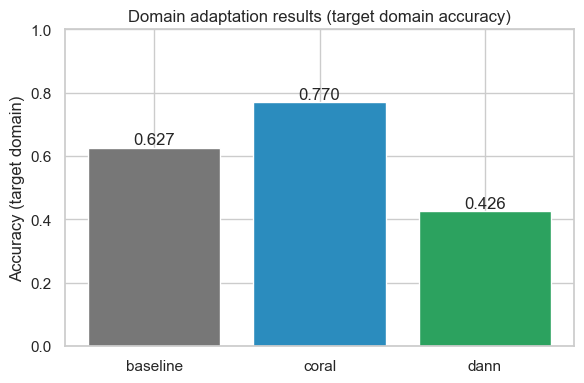

Saved plot to: C:\Users\alfiy\ByteBuzz\Notebooks\plots\domain_adapt_accs_20251017_232158.png


In [24]:
#Summarize results, save reports & plots
# Build summary
summary = {
    "timestamp": timestamp,
    "n_src": int(X_src.shape[0]),
    "n_tgt": int(X_tgt.shape[0]),
    "baseline_acc": float(acc),
    "baseline_f1": float(f1),
    "coral_acc": float(acc_coral),
    "coral_f1": float(f1_coral),
    "dann_acc": float(dann_acc) if (TORCH_AVAILABLE and dann_acc is not None) else None,
    "dann_f1": float(dann_f1) if (TORCH_AVAILABLE and dann_f1 is not None) else None,
    "notes": {
        "domain_column_used": DOMAIN_COL,
        "target_column": TARGET_COL,
        "domain_construction": "synthetic" if "target_synthetic" in df[DOMAIN_COL].unique() else "original"
    }
}
save_json(summary, REPORTS_DIR / f"domain_adapt_summary_{timestamp}.json")
print("Saved summary to reports.")

# Save classification reports
save_json({"baseline_report": baseline_report, "coral_report": coral_report}, REPORTS_DIR / f"domain_reports_basic_{timestamp}.json")
if TORCH_AVAILABLE and dann_acc is not None:
    # compute classification report for DANN predictions
    dann_report = classification_report(y_tgt_enc, preds_tgt, output_dict=True, zero_division=0)
    save_json({"dann_report": dann_report}, REPORTS_DIR / f"domain_report_dann_{timestamp}.json")

# Plots: bar chart of accuracies
accs = {
    "baseline": acc,
    "coral": acc_coral,
}
if TORCH_AVAILABLE and dann_acc is not None:
    accs["dann"] = dann_acc

plt.figure(figsize=(6,4))
plt.bar(list(accs.keys()), list(accs.values()), color=["#777777","#2b8cbe","#2ca25f"][:len(accs)])
plt.ylim(0,1)
plt.ylabel("Accuracy (target domain)")
plt.title("Domain adaptation results (target domain accuracy)")
for i,(k,v) in enumerate(accs.items()):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center")
plt.tight_layout()
plot_path = PLOTS_DIR / f"domain_adapt_accs_{timestamp}.png"
plt.savefig(plot_path, dpi=180)
plt.show()
print("Saved plot to:", plot_path)


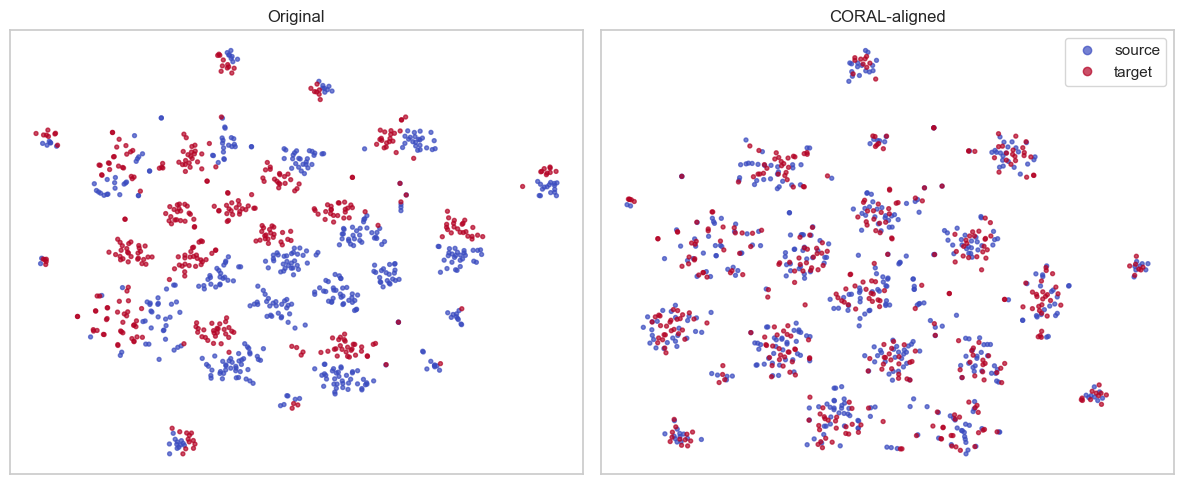

Saved t-SNE figure to: C:\Users\alfiy\ByteBuzz\Notebooks\plots\tsne_coral_20251017_232158.png


In [25]:
#Diagnostics: t-SNE before/after CORAL
# t-SNE visualization to inspect alignment (optional — small sample)
from sklearn.manifold import TSNE

# sample up to 1000 points
n_sample = min(1000, len(X_src_s)+len(X_tgt_s))
idx_src = np.random.choice(len(X_src_s), size=min(len(X_src_s), n_sample//2), replace=False)
idx_tgt = np.random.choice(len(X_tgt_s), size=min(len(X_tgt_s), n_sample//2), replace=False)

X_vis_src = X_src_s[idx_src]
X_vis_tgt = X_tgt_s[idx_tgt]
y_vis_src = y_src_enc[idx_src]
y_vis_tgt = y_tgt_enc[idx_tgt]

X_vis_comb = np.vstack([X_vis_src, X_vis_tgt])
labels_domain = np.array([0]*len(X_vis_src) + [1]*len(X_vis_tgt))
labels_class = np.hstack([y_vis_src, y_vis_tgt])

# t-SNE on original
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, init="random")
emb_orig = tsne.fit_transform(X_vis_comb)

# t-SNE on CORAL-aligned source + target (recompute)
X_vis_src_coral = coral(X_vis_src, X_vis_tgt)
emb_coral = tsne.fit_transform(np.vstack([X_vis_src_coral, X_vis_tgt]))

# Plot side-by-side
fig, axes = plt.subplots(1,2, figsize=(12,5))
for ax, emb, title in zip(axes, (emb_orig, emb_coral), ("Original", "CORAL-aligned")):
    sc = ax.scatter(emb[:,0], emb[:,1], c=labels_domain, cmap="coolwarm", alpha=0.7, s=8)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
plt.legend(handles=sc.legend_elements()[0], labels=["source","target"])
plt.tight_layout()
tsne_path = PLOTS_DIR / f"tsne_coral_{timestamp}.png"
plt.savefig(tsne_path, dpi=180)
plt.show()
print("Saved t-SNE figure to:", tsne_path)
